# Final Comparison of Gibbs Samplers

In this notebook, we will compare the performance of the batched and sequential Gibbs samplers on small, large, and real datasets. We will also compare these results with the spectral clustering approach. The objectives are:
- To show that the batched version reaches a similar solution to the sequential one.
- To assess the convergence speed of the samplers.
- To compare the results with spectral clustering.

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neal_sequential import Neal_sequential_Gibbs_sampler
from neal_batched import Neal_batched_Gibbs_sampler
import utils
from utils import warm_initializer, progressive_R_hat, salso
from metrics import loss, greedy_loss
from sklearn.cluster import SpectralClustering
from sbm_class import Homogeneous_SBM, SBM  # Import the SBM class for network generation
from utils import find_convergence

## Simulation on a small dataset

In [85]:
# random seed
seed = 123

# Parameters for the small network
p = 0.18
q = 0.08
n_small = 400  # number of nodes
k = 4          # number of communities

# Generate a small synthetic dataset using the SBM class
sbm = Homogeneous_SBM(n=n_small, k=k, p=p, q=q)
adj_matrix, z_true_small = sbm.get_A(), sbm.get_z()

# Warm initialization
alpha = 0.3 # initial misclassification rate
z_init_small = warm_initializer(z_true_small, alpha, n_small, k)

In [86]:
# Sampler parameters
alpha_p = 1
alpha_q = 1
beta_p = 1
beta_q = 1
n_iter = 100
gamma = 1

In [87]:
import time

# Initialize and run sequential sampler
start_time = time.time()
sequential_sampler = Neal_sequential_Gibbs_sampler(adj_matrix, z_init_small, alpha_p, beta_p, alpha_q, beta_q, gamma)
sequential_sampler.run(n_iter)
sequential_time = time.time() - start_time
sequential_p_list_small = sequential_sampler.get_p_list()
sequential_q_list_small = sequential_sampler.get_q_list()
sequential_z_list_small = sequential_sampler.get_z_list()

# Initialize and run batched sampler
start_time = time.time()
batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_init_small, alpha_p, beta_p, alpha_q, beta_q, gamma)
batched_sampler.run(n_iter)
batched_time = time.time() - start_time
batched_p_list_small = batched_sampler.get_p_list()
batched_q_list_small = batched_sampler.get_q_list()
batched_z_list_small = batched_sampler.get_z_list()

print(f"Sequential sampler time: {sequential_time} seconds")
print(f"Batched sampler time: {batched_time} seconds")

100%|██████████| 100/100 [00:00<00:00, 123.47it/s]

Sequential sampler time: 2.658919095993042 seconds
Batched sampler time: 0.8099286556243896 seconds


In [88]:
# ratio of times
print(f"Ratio of times: {sequential_time/batched_time}")

Ratio of times: 3.2829053244735857


In [89]:
# compute loss
sequential_loss_small = [loss(z, z_true_small)[0] for z in sequential_z_list_small]
batched_loss_small = [loss(z, z_true_small)[0] for z in batched_z_list_small]

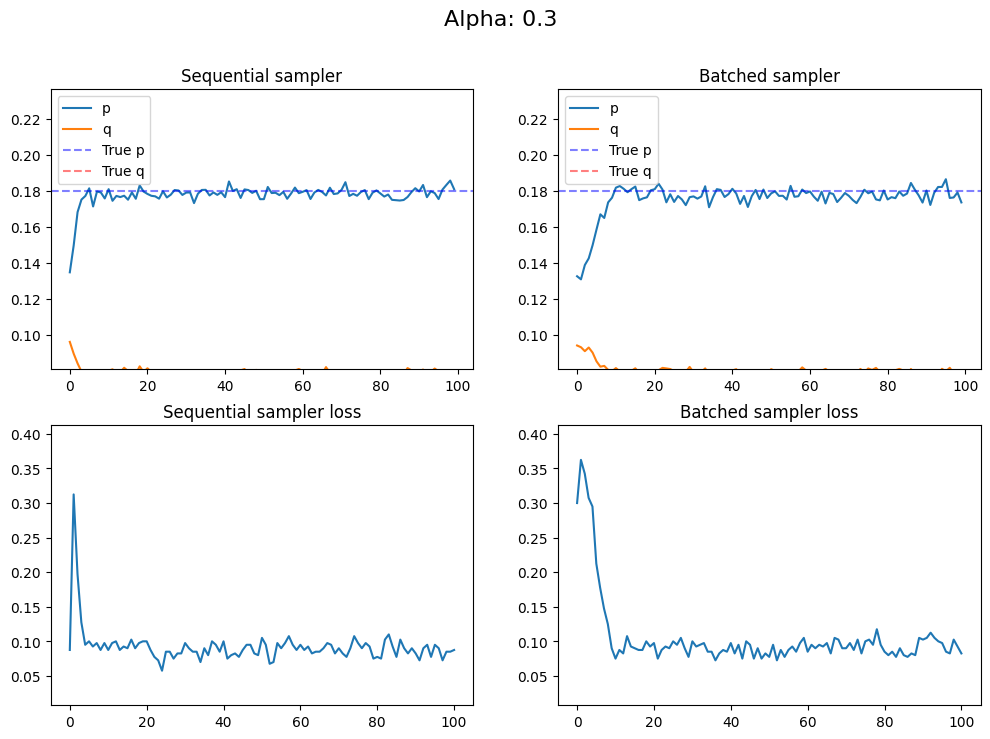

In [90]:
# plot the traces of p and q in the same plot, on the left for sequential and on the right for batched, and below the same for the loss
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First row: p and q comparison
axs[0, 0].plot(sequential_p_list_small, label='p')
axs[0, 0].plot(sequential_q_list_small, label='q')
axs[0, 0].axhline(y=p, color='b', linestyle='--', label='True p', alpha=0.5)
axs[0, 0].axhline(y=q, color='r', linestyle='--', label='True q', alpha=0.5)
axs[0, 0].set_title('Sequential sampler')
axs[0, 0].legend()

axs[0, 1].plot(batched_p_list_small, label='p')
axs[0, 1].plot(batched_q_list_small, label='q')
axs[0, 1].axhline(y=p, color='b', linestyle='--', label='True p', alpha=0.5)
axs[0, 1].axhline(y=q, color='r', linestyle='--', label='True q', alpha=0.5)
axs[0, 1].set_title('Batched sampler')
axs[0, 1].legend()

# Set the same vertical scale for p and q comparison
p_min = min(min(sequential_p_list_small), min(batched_p_list_small))-0.05
p_max = max(max(sequential_p_list_small), max(batched_p_list_small))+0.05
q_min = min(min(sequential_q_list_small), min(batched_q_list_small))-0.05
q_max = max(max(sequential_q_list_small), max(batched_q_list_small))+0.05
axs[0, 0].set_ylim(p_min, p_max)
axs[0, 1].set_ylim(p_min, p_max)

# Second row: loss comparison
axs[1, 0].plot(sequential_loss_small)
axs[1, 0].set_title('Sequential sampler loss')

axs[1, 1].plot(batched_loss_small)
axs[1, 1].set_title('Batched sampler loss')

# Set the same vertical scale for loss comparison
loss_min = min(min(sequential_loss_small), min(batched_loss_small))-0.05
loss_max = max(max(sequential_loss_small), max(batched_loss_small))+0.05
axs[1, 0].set_ylim(loss_min, loss_max)
axs[1, 1].set_ylim(loss_min, loss_max)

# Add the value of alpha to the top of the figure
fig.suptitle(f'Alpha: {alpha}', fontsize=16)

plt.show()

In [91]:
# find the point estimate for both
sequential_z_hat_small = salso(sequential_z_list_small[20:])

batched_z_hat_small = salso(batched_z_list_small[20:])

loss(sequential_z_hat_small, z_true_small)[0]*n_small, loss(batched_z_hat_small, z_true_small)[0]*n_small

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



(27.0, 27.0)

In [81]:
# Check convergence iteration
# run the samplers again, with a different initialization, and store the loss again, then add in sequential_loss_list the 
# list of the two loss lists
sequential_loss_list = []
batched_loss_list = []
np.random.seed(seed=123)
n_chains = 4
for i in range(n_chains):
    # Warm initialization
    z_init_small = warm_initializer(z_true_small, alpha, n=n_small, k=k)
    
    # Initialize and run sequential sampler
    sequential_sampler = Neal_sequential_Gibbs_sampler(adj_matrix, z_init_small, alpha_p, beta_p, alpha_q, beta_q, gamma)
    sequential_sampler.run(n_iter)
    sequential_z_list_small = sequential_sampler.get_z_list()[1:]
    sequential_loss_small = [loss(z, z_true_small)[0] for z in sequential_z_list_small]
    sequential_loss_list.append(sequential_loss_small)

while len(batched_loss_list) < n_chains:  
    # Initialize and run batched sampler
    z_init_small = warm_initializer(z_true_small, alpha, n=n_small, k=k)
    batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_init_small, alpha_p, beta_p, alpha_q, beta_q, gamma)
    batched_sampler.run(n_iter)
    batched_z_list_small = batched_sampler.get_z_list()[1:]
    batched_loss_small = [loss(z, z_true_small)[0] for z in batched_z_list_small]
    
    # Check if the loss is below the threshold
    if batched_loss_small[-1]< 0.3:
        batched_loss_list.append(batched_loss_small)
    else:
        print(f"Loss too high: {batched_loss_small[-1]}")

sequential_r_hat_small = progressive_R_hat(sequential_loss_list)
batched_r_hat_small = progressive_R_hat(batched_loss_list)

lb = 0.95
ub = 1.1
print(find_convergence(sequential_r_hat_small, ub = ub, lb = lb))
print(find_convergence(batched_r_hat_small, ub = ub, lb = lb))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 119.15it/s]


Loss too high: 0.7175


100%|██████████| 100/100 [00:00<00:00, 115.28it/s]


Loss too high: 0.71


100%|██████████| 100/100 [00:00<00:00, 116.04it/s]


Loss too high: 0.715


100%|██████████| 100/100 [00:00<00:00, 116.27it/s]


Loss too high: 0.7025


100%|██████████| 100/100 [00:00<00:00, 121.10it/s]


Loss too high: 0.7025


100%|██████████| 100/100 [00:00<00:00, 121.21it/s]


Loss too high: 0.72


100%|██████████| 100/100 [00:00<00:00, 120.12it/s]


8
18


100%|██████████| 50/50 [00:00<00:00, 117.29it/s]


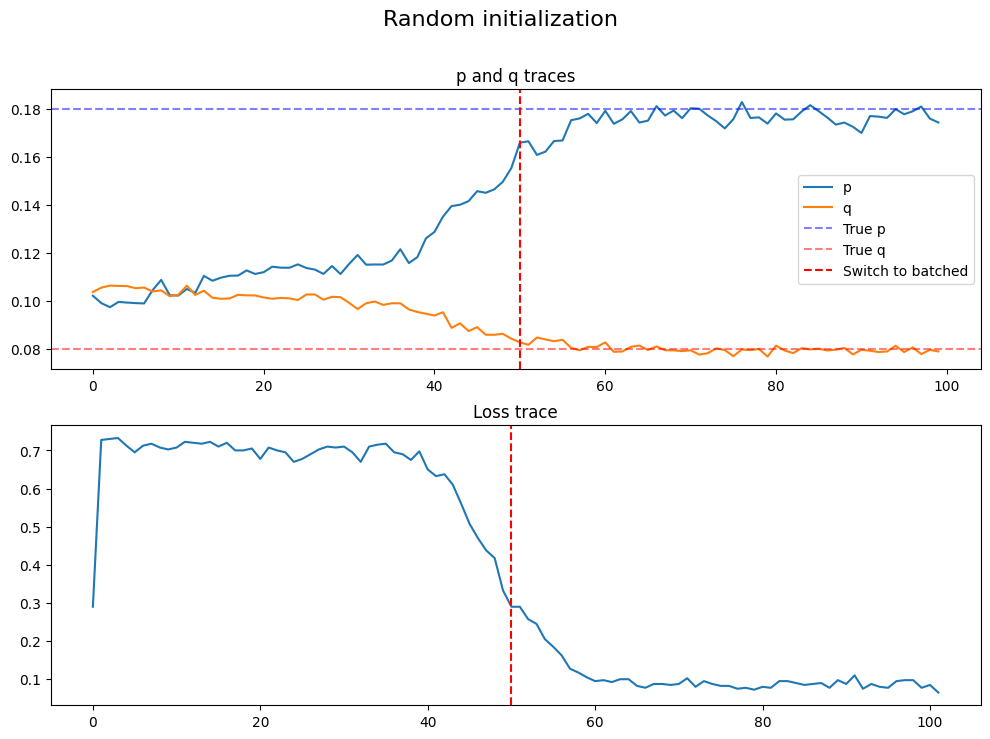

In [80]:
np.random.seed(seed=123)
# chaining methods
n_iter_seqeuntial = 50
n_iter_batched = 50
# random intiialization
z_init_small = np.random.choice(k, n_small)
# Initialize and run sequential sampler
sequential_sampler = Neal_sequential_Gibbs_sampler(adj_matrix, z_init_small, alpha_p, beta_p, alpha_q, beta_q, gamma)
sequential_sampler.run(n_iter_seqeuntial)
sequential_z_list_small = sequential_sampler.get_z_list()
sequential_p_list_small = sequential_sampler.get_p_list()
sequential_q_list_small = sequential_sampler.get_q_list()
z_final = sequential_z_list_small[-1]
# Initialize and run batched sampler
batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_final, alpha_p, beta_p, alpha_q, beta_q, gamma)
batched_sampler.run(n_iter_batched)
batched_z_list_small = batched_sampler.get_z_list()
batched_p_list_small = batched_sampler.get_p_list()
batched_q_list_small = batched_sampler.get_q_list()

# chain the z_lists
z_list = sequential_z_list_small + batched_z_list_small
# chain the p_lists
p_list = sequential_p_list_small + batched_p_list_small
# chain the q_lists
q_list = sequential_q_list_small + batched_q_list_small
# compute loss
loss_list = [loss(z, z_true_small)[0] for z in z_list]

# plot traces of p and q in the same subplot, and on the same line add the subplot of the loss
# add a text on top saying "random initialization"
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# First row: p and q comparison
axs[0].plot(p_list, label='p')
axs[0].plot(q_list, label='q')
axs[0].axhline(y=p, color='b', linestyle='--', label='True p', alpha=0.5)
axs[0].axhline(y=q, color='r', linestyle='--', label='True q', alpha=0.5)
axs[0].axvline(n_iter_seqeuntial, color='r', linestyle='--', label='Switch to batched')
axs[0].set_title('p and q traces')
axs[0].legend()

# Second row: loss comparison
axs[1].plot(loss_list)
axs[1].axvline(n_iter_seqeuntial, color='r', linestyle='--', label='Switch to batched')
axs[1].set_title('Loss trace')

# Add the value of alpha to the top of the figure
fig.suptitle(f'Random initialization', fontsize=16)

plt.show()


# Large Network

It will require using a greedy loss instead of the standard one.

In [11]:
np.random.seed(seed)

n_large = 4000
k = 25
p = 0.18
q = 0.08

# Generate a large synthetic dataset using the SBM class
sbm = Homogeneous_SBM(n=n_large, k=k, p=p, q=q)
adj_matrix, z_true_large = sbm.get_A(), sbm.get_z()

# Warm initialization
alpha = 0.35  # initial misclassification rate
z_init_large = warm_initializer(z_true_large, alpha, n_large, k)

# Sampler parameters
alpha_p = 1
alpha_q = 1
beta_p = 1
beta_q = 1
n_iter = 100
gamma = 1

In [12]:
# Initialize and run sequential sampler
sequential_sampler = Neal_sequential_Gibbs_sampler(adj_matrix, z_init_large, alpha_p, beta_p, alpha_q, beta_q, gamma)
sequential_sampler.run(n_iter)
sequential_p_list_large = sequential_sampler.get_p_list()
sequential_q_list_large = sequential_sampler.get_q_list()
sequential_z_list_large = sequential_sampler.get_z_list()
sequential_loss_list_large = [greedy_loss(z, z_true_large) for z in sequential_z_list_large]

100%|██████████| 100/100 [08:13<00:00,  4.93s/it]


In [13]:
# Initialize and run batched sampler
batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_init_large, alpha_p, beta_p, alpha_q, beta_q, gamma)
batched_sampler.run(n_iter)
batched_p_list_large = batched_sampler.get_p_list()
batched_q_list_large = batched_sampler.get_q_list()
batched_z_list_large = batched_sampler.get_z_list()
batched_loss_list_large = [greedy_loss(z, z_true_large) for z in batched_z_list_large]

100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


In [14]:
4.53*1.43

6.4779

In [15]:
# # Compare trace plots of batched samplers (p and q on the first row, greedy loss on the second row)
# fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# # First row: p and q comparison
# axs[0].plot(batched_p_list_large, label='p')
# axs[0].plot(batched_q_list_large, label='q')
# axs[0].set_title('Batched sampler')
# axs[0].legend()

# # Second row: loss comparison
# axs[1].plot(batched_loss_list_large)
# axs[1].set_title('Batched sampler loss')

# plt.show()

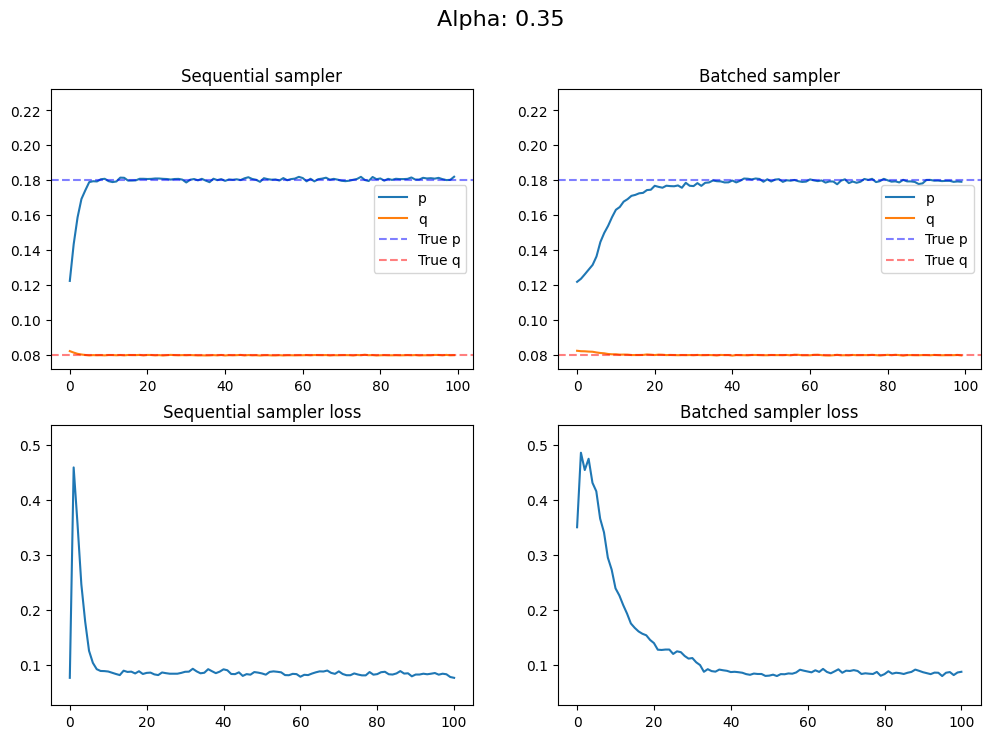

In [16]:
# plot the traces of p and q in the same plot, on the left for sequential and on the right for batched, and below the same for the loss
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First row: p and q comparison
axs[0, 0].plot(sequential_p_list_large, label='p')
axs[0, 0].plot(sequential_q_list_large, label='q')
axs[0, 0].axhline(y=p, color='b', linestyle='--', label='True p', alpha=0.5)
axs[0, 0].axhline(y=q, color='r', linestyle='--', label='True q', alpha=0.5)
axs[0, 0].set_title('Sequential sampler')
axs[0, 0].legend()

axs[0, 1].plot(batched_p_list_large, label='p')
axs[0, 1].plot(batched_q_list_large, label='q')
axs[0, 1].axhline(y=p, color='b', linestyle='--', label='True p', alpha=0.5)
axs[0, 1].axhline(y=q, color='r', linestyle='--', label='True q', alpha=0.5)
axs[0, 1].set_title('Batched sampler')
axs[0, 1].legend()

# Set the same vertical scale for p and q comparison
p_min = min(min(sequential_p_list_large), min(batched_p_list_large))-0.05
p_max = max(max(sequential_p_list_large), max(batched_p_list_large))+0.05
q_min = min(min(sequential_q_list_large), min(batched_q_list_large))-0.05
q_max = max(max(sequential_q_list_large), max(batched_q_list_large))+0.05
axs[0, 0].set_ylim(p_min, p_max)
axs[0, 1].set_ylim(p_min, p_max)

# Second row: loss comparison
axs[1, 0].plot(sequential_loss_list_large)
axs[1, 0].set_title('Sequential sampler loss')

axs[1, 1].plot(batched_loss_list_large)
axs[1, 1].set_title('Batched sampler loss')

# Set the same vertical scale for loss comparison
loss_min = min(min(sequential_loss_list_large), min(batched_loss_list_large))-0.05
loss_max = max(max(sequential_loss_list_large), max(batched_loss_list_large))+0.05
axs[1, 0].set_ylim(loss_min, loss_max)
axs[1, 1].set_ylim(loss_min, loss_max)

# Add the value of alpha to the top of the figure
fig.suptitle(f'Alpha: {alpha}', fontsize=16)

plt.show()


In [17]:
# compare point estimates
convergence_iterate = 50
sequential_z_hat_large = salso(sequential_z_list_large[convergence_iterate:])
batched_z_hat_large = salso(batched_z_list_large[convergence_iterate:])
greedy_loss(sequential_z_hat_large, z_true_large)*n_large

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



220.0

In [18]:
# loss for batched
print(greedy_loss(batched_z_hat_large, z_true_large)*n_large)

# loss for sequential
print(greedy_loss(sequential_z_hat_large, z_true_large)*n_large)

221.0
220.0


In [19]:
# find convergence iteration
n_chains = 4
sequential_loss_list_large_r = []
batched_loss_list_large_r = []

for i in range(n_chains):
    # Warm initialization
    z_init_large = warm_initializer(z_true_large, alpha, n_large, k)
    
    # Initialize and run sequential sampler
    sequential_sampler = Neal_sequential_Gibbs_sampler(adj_matrix, z_init_large, alpha_p, beta_p, alpha_q, beta_q, gamma)
    sequential_sampler.run(n_iter)
    sequential_z_list_large = sequential_sampler.get_z_list()[1:]
    sequential_loss_large = [greedy_loss(z, z_true_large) for z in sequential_z_list_large]
    sequential_loss_list_large_r.append(sequential_loss_large)


100%|██████████| 100/100 [07:35<00:00,  4.55s/it]


In [27]:
while len(batched_loss_list_large_r) < n_chains:  
    # Initialize and run batched sampler
    z_init_large = warm_initializer(z_true_large, alpha, n_large, k)
    batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_init_large, alpha_p, beta_p, alpha_q, beta_q, gamma)
    batched_sampler.run(n_iter)
    batched_z_list_large = batched_sampler.get_z_list()[1:]
    batched_loss_large = [greedy_loss(z, z_true_large) for z in batched_z_list_large]
    
    # Check if the loss is below the threshold
    if batched_loss_large[-1]< 0.2:
        batched_loss_list_large_r.append(batched_loss_large)
    else:
        print(f"Loss too high: {batched_loss_large[-1]}")

sequential_r_hat_large = progressive_R_hat(sequential_loss_list_large_r)
batched_r_hat_large = progressive_R_hat(batched_loss_list_large_r)

lb = 0.95
ub = 1.1
print(find_convergence(sequential_r_hat_large, ub = ub, lb = lb))
print(find_convergence(batched_r_hat_large, ub = ub, lb = lb))

9
38


In [41]:
np.random.seed(seed=123)
# chaining methods
n_iter_sequential = 500
n_iter_batched = 200
# random intiialization
z_init_large = np.random.choice(k, n_large)

# Initialize and run sequential sampler
sequential_sampler = Neal_sequential_Gibbs_sampler(adj_matrix, z_init_large, alpha_p, beta_p, alpha_q, beta_q, gamma)
sequential_sampler.run(n_iter_sequential)
sequential_z_list_large = sequential_sampler.get_z_list()
sequential_p_list_large = sequential_sampler.get_p_list()
sequential_q_list_large = sequential_sampler.get_q_list()
z_final = sequential_z_list_large[-1]

100%|██████████| 500/500 [40:29<00:00,  4.86s/it]


In [42]:
# Initialize and run batched sampler
batched_sampler = Neal_batched_Gibbs_sampler(adj_matrix, z_final, alpha_p, beta_p, alpha_q, beta_q, gamma)
batched_sampler.run(n_iter_batched)
batched_z_list_large = batched_sampler.get_z_list()
batched_p_list_large = batched_sampler.get_p_list()
batched_q_list_large = batched_sampler.get_q_list()

100%|██████████| 200/200 [02:40<00:00,  1.25it/s]


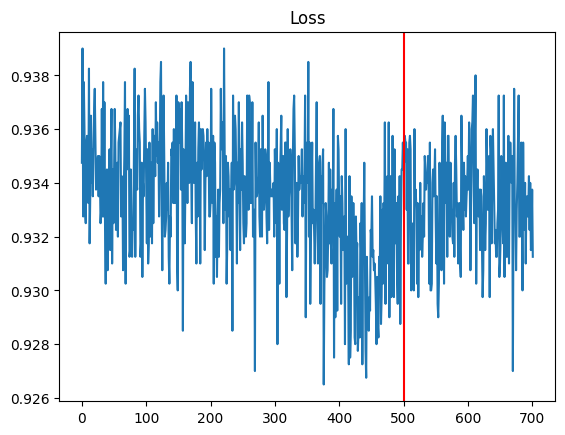

In [43]:

# Chain the z_lists
z_list = sequential_z_list_large + batched_z_list_large
# Chain the p_lists
p_list = sequential_p_list_large + batched_p_list_large
# Chain the q_lists
q_list = sequential_q_list_large + batched_q_list_large
# Compute loss
loss_list = [greedy_loss(z, z_true_large) for z in z_list]
# Plot the loss
plt.plot(loss_list)
# Add vertical line when method switches
plt.axvline(n_iter_sequential, color='r')
plt.title('Loss')
plt.show()

## Real Data

In [158]:
import networkx as nx

# import the data from the ./data folder, .txt files
data = np.loadtxt('./data/email-Eu-core.txt', dtype=int)
assignments = np.loadtxt('./data/email-Eu-core-department-labels.txt', dtype=int)

# turn data into an adjacency matrix
G = nx.Graph()
G.add_edges_from(data)
A = nx.adjacency_matrix(G).toarray()

z_true = assignments[:,1]
n = A.shape[0]
k = len(np.unique(z_true))
print('Number of nodes:', n)
print('Number of communities:', k)
# count unique values in z_true
np.unique(z_true).shape[0]
# rename communities from 0 to k-1
for i, z in enumerate(np.unique(z_true)):
    z_true[z_true == z] = i

Number of nodes: 1005
Number of communities: 42


In [159]:
# reset seed
np.random.seed(seed)

In [175]:
n_iter = 20
z_init = warm_initializer(z_true, alpha = 0.0, n=n, k=k)
sampler = Neal_batched_Gibbs_sampler(A, z_init, alpha_p, beta_p, alpha_q, beta_q, gamma=1)
sampler.run(n_iter)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 16.83it/s]


In [176]:
# compute the greedy loss
z_list = sampler.get_z_list()
z_hat = salso(z_list[10:])

greedy_loss(z_hat, z_true)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In salso(mat, maxZealousAttempts = 10000) :
R[write to console]: 
 
R[write to console]:  The number of clusters equals the default maximum possible number of clusters.



0.5701492537313433